# Simulations notebook

## Simulated data

### Poisson-logNormal $Z_i \sim N(\mu_i, \sigma_i^2)$

Set our latent $Z_i, i=1, \dots, 9$ with $Z_i \sim N(\mu_i, \sigma_i^2)$.

In [5]:
import sys
#if branch is stable, will install via pypi, else will install from source
branch = "latest"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install cpa-tools
    !pip install scanpy
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install git+https://github.com/theislab/cpa
    !pip install scanpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 2.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
  Cloning https://github.com/theislab/cpa to /tmp/pip-req-build-u_jl62ti
  Running command git clone --filter=blob:none --quiet https://github.com/theislab/cpa /tmp/pip-req-build-u_jl62ti
  Resolved https://github.com/theislab/cpa to commit 7cda37e9cca2078af1b2373dc6f9422a5bc6f87d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [6]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import scanpy as sc

In [7]:
print(np.__version__)

1.23.5


In [8]:
K = 5
n = 20000 # number of cells
N = G = 1000 # number of genes
np.random.seed(123)
mu = np.linspace(1,K,K) #np.random.uniform(0,1, K)
Z = np.random.normal(mu,0.1)

Linear model for each cell $i$, $ X_i = BZ_i + \epsilon$
ie for $K$ "modules" $Z_1,\dots, Z_K$

$X_{i} = \sum_k B_{ik}Z_k + \epsilon_i$, $\epsilon_i \sim N(0, \sigma_0^2 I_{G})$

Non linear transformation for count data: poisson lognormal $X_i \sim \mathcal{P}(e^{BZ_i+\epsilon})$

Here $N = G = 1000$

In [ ]:
#def non_linear_transform(X, f=None):
#    if f == 'exp':
#        return np.exp(-X)
#    if f == 'tanh':
#        return np.tanh(X)
#    if f == 'roll':
#        return X*np.cos(X)
#    else:
#       return np.cos(X)
#f = 'roll'
#sigma0 = np.var(non_linear_transform(B@Z, f=f))*0.3
#X_nl = non_linear_transform(B@Z, f=f)


In [19]:
N = 1000
p = 0.3
freq = [0.2, 0.4, 0.1, 0.1, 0.2]
a = np.random.choice(K, size=N, p=freq)
b = np.zeros((a.size, a.max() + 1))
b[np.arange(a.size), a] = 1
b.shape

(1000, 5)

In [3]:
def poisson_lognormal(Z,sigma0=None, seed=None):
    if seed!=None:
        np.random.seed(seed)
    if sigma0 ==None:
      sigma0 = np.sqrt(np.var(Z))*0.3

    eps = np.random.normal(0,sigma0, size=Z.shape[0])
    lam = np.exp(Z+eps)
    return np.random.poisson(lam)

In [20]:
N = 1000
p = 0.3
freq = [0.2, 0.4, 0.1, 0.1, 0.2]
def randbin(m, n, p, seed=123):
    np.random.seed(seed)
    return np.random.choice([0, 1], size=(m,n), p=[p, 1-p])

def membership_matrix(K, N, freq, seed=123):
  np.random.seed(seed)
  a = np.random.choice(K, size=N, p=freq)
  b = np.zeros((a.size, a.max() + 1))
  b[np.arange(a.size), a] = 1
  return b

B = membership_matrix(K,N,freq)
sigma0 = np.var(B@Z)*0.3
eps = np.random.normal(0,sigma0, size=N)
X = poisson_lognormal(B@Z)

In [23]:
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

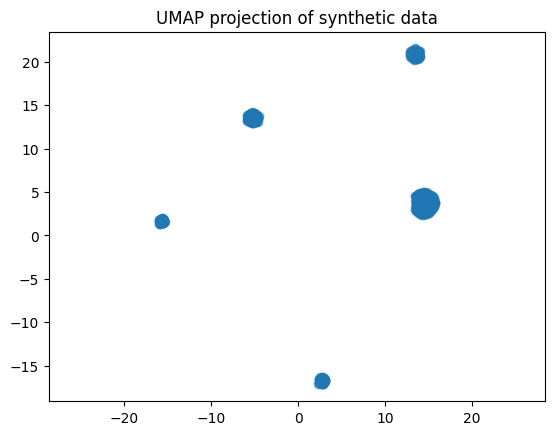

In [24]:
reducer = umap.UMAP()
scaled_Z = StandardScaler().fit_transform((B@Z).reshape(-1,1))
embedding = reducer.fit_transform(scaled_Z)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    alpha=0.5
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of synthetic data', fontsize=12);


In [25]:
B.shape

(1000, 5)

In [26]:
keys = ['module_{}'.format(i) for i in range(K)]
B_dict = dict(zip(keys, B.T))

#### add interventions

Add interventions vector $d \in \mathbb{R}^G$, in a linear model $X_i(d) = \text{Poisson-lognormal}((B \otimes d) Z_i + \epsilon_i)$ where $d$ such that $d_k = 0$ for blocked genes, $d_k = 1$ for not blocked.

Recall $B \in \mathbb{R}^{N\times K}$ is a dictionary for gene interaction mapping $N$ genes to $K$ modules. So intervention blocking gene $g$ should set row $g$ to zero in $B$ ($0_{1 \times K}$ vector).

<Axes: >

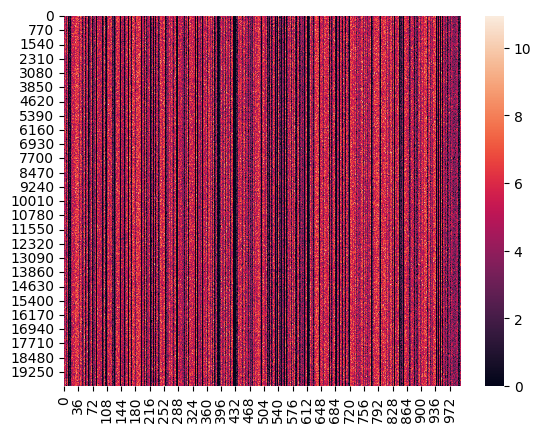

In [13]:
import seaborn as sns
sns.heatmap(np.log(1+X))

Example for one observation in 1000 copies: define knocked out genes.

In [41]:
d=np.ones(N)
d[20] = d[10] = d[3] =d[1]= d[15]= 0 # set genes 3, 10 and 100 as knock out.
B_d = np.multiply(B.T,d).T

In [42]:
(B_d@Z).shape

(1000,)

In [43]:
X = np.array([poisson_lognormal(B@Z) for i in range(1000)])
X_d = np.array([poisson_lognormal(B_d@Z) for i in range(1000)])

In [44]:
reducer = umap.UMAP()
scaled_X_d = StandardScaler().fit_transform(X_d)
embedding_d = reducer.fit_transform(scaled_X_d)
embedding_d.shape

(1000, 2)

<Axes: title={'center': 'X with knocked out genes'}>

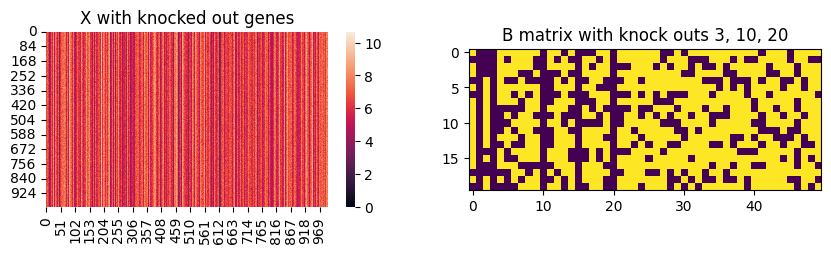

In [45]:
import seaborn as sns
plt.figure(figsize=(10,5))
plt.subplot(222).set_title('B matrix with knock outs 3, 10, 20')
plt.imshow(B_d[:50,:].T)
plt.subplot(221).set_title('X with knocked out genes')
sns.heatmap(np.log(1+X_d))

#plt.scatter((B@Z)[:,0],(B@Z)[:,1], color='orange', alpha=1, label='all observed')
#plt.scatter((B_d@Z)[:,0],(B_d@Z)[:,1], color='blue', alpha=0.2, label='with knock outs')


In [49]:
X[:10,3],X_d[:10,3]

(array([343, 119, 138, 263, 105, 121, 201, 357, 589, 204]),
 array([3, 0, 2, 1, 0, 1, 1, 1, 0, 2]))

Text(0.5, 1.0, 'observation space between two genes for unperturbed versus with knock outs')

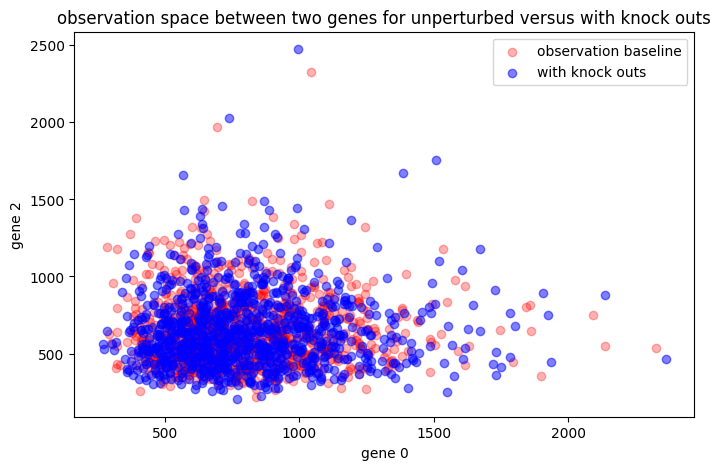

In [47]:
g1 = 0
g2 = 2
plt.figure(figsize=(8,5))
plt.scatter(X[:,g1],X[:,g2], color='red', alpha=0.3, label='observation baseline')
plt.scatter(X_d[:,g1],X_d[:,g2], color='blue', alpha=0.5, label='with knock outs')
plt.xlabel('gene {}'.format(g1))
plt.ylabel('gene {}'.format(g2))
plt.legend()
plt.title('observation space between two genes for unperturbed versus with knock outs')

Text(0.5, 1.0, 'observation space between two genes for unperturbed versus with knock outs')

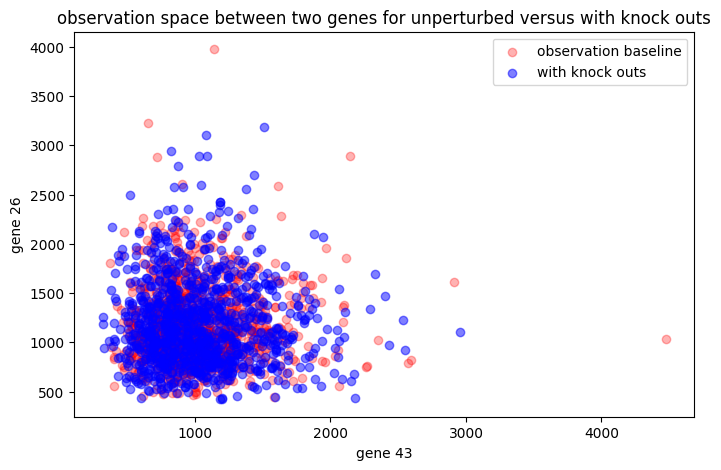

In [48]:
g1 = 43
g2 = 26
plt.figure(figsize=(8,5))
plt.scatter(X[:,g1],X[:,g2], color='red', alpha=0.3, label='observation baseline')
plt.scatter(X_d[:,g1],X_d[:,g2], color='blue', alpha=0.5, label='with knock outs')
plt.xlabel('gene {}'.format(g1))
plt.ylabel('gene {}'.format(g2))
plt.legend()
plt.title('observation space between two genes for unperturbed versus with knock outs')

Define the perturbations. Assume 10 different perturbations chosen at random.
Add 10 perturbations that are linear combinations of the 20 perturbations.

In [50]:
# assume 10 different perturbations, chosen at random.
# will be binary array od 1000 values
M_pert = np.zeros((20, 1000)).astype('int')
M_pert[:10,:] = randbin(10,N, p, seed=999).astype('int')

M_pert.shape

(20, 1000)

In [51]:
for i in range(5):
    M_pert[10+i,:] = np.bitwise_or(M_pert[i,:],M_pert[i+1,:])

In [52]:
for i in range(5):
    M_pert[15+i,:] = np.bitwise_or(M_pert[i,:],M_pert[9-i,:])

Note that perturbations 0 to 9 are single perturbations, perturbations 10 to 14 are combinations of adjacent perturbations: pert_0+pert_1, pert_1+pert_2, ... and perturbations 15 to 19 are combinations of pert_0+pert_9, pert_1+pert_8, pert_2+pert_7, pert_3+pert_6, pert_4+pert_5.

Extend it to 20 000 observations: dictionary of perturbations.


Text(0, 0.5, 'Frequency')

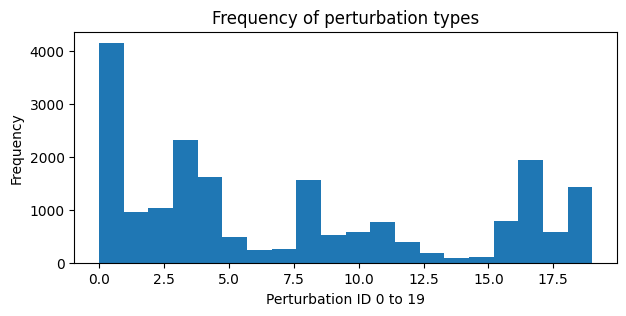

In [53]:
np.random.seed(999)
pert_keys = np.random.choice([i for i in range(20)],20000, p = [0.2, 0.05, 0.05, 0.12, 0.08, 0.025, 0.0125, 0.0125, 0.075, 0.025, 0.03, 0.04, 0.02, 0.01, 0.005, 0.005, 0.04, 0.1, 0.03, 0.07])
plt.figure(figsize=(7,3))
plt.hist(pert_keys,bins=20)
plt.title("Frequency of perturbation types")
plt.xlabel("Perturbation ID 0 to 19")
plt.ylabel('Frequency')

In [54]:
D_pert = np.array([M_pert[pert_keys[i],:] for i in range(20000)]).reshape(20000,1000)

<Axes: >

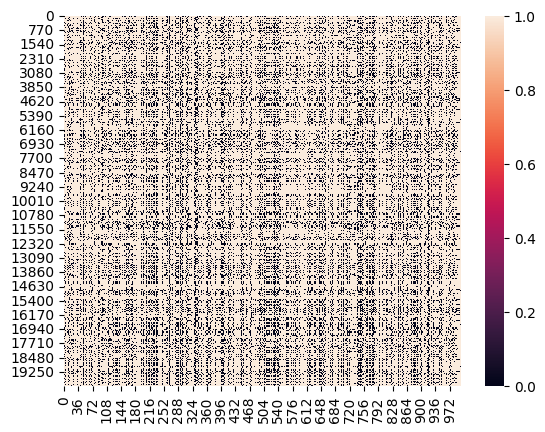

In [55]:
sns.heatmap(D_pert)

In [56]:
from tqdm import tqdm

In [75]:
X_d = np.empty((20000,1000))
X_baseline = np.empty((20000,1000))
for i in tqdm(range(20000)):
    d = D_pert[i,:]
    X_d[i,:] = poisson_lognormal(np.multiply(B.T,d).T@Z)
    X_baseline[i,:] = poisson_lognormal(B@Z)

100%|██████████| 20000/20000 [00:31<00:00, 638.22it/s]


Text(0.5, 1.0, 'baseline')

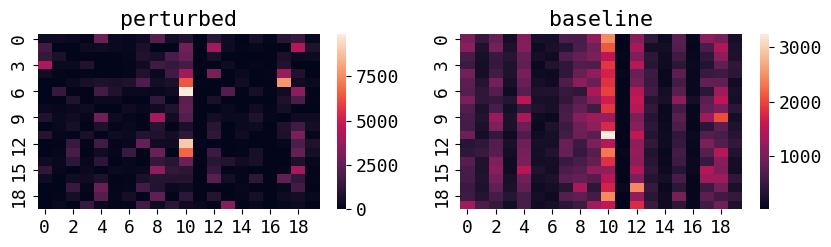

In [78]:
plt.figure(figsize=(10,5))
plt.subplot(221)
sns.heatmap(X_d[:20,:20])
plt.title('perturbed')
plt.subplot(222)
sns.heatmap(X_baseline[:20,:20])
plt.title('baseline')

#### Transform to AnnData and pass through CPA

In [59]:
import anndata as ad

In [60]:
X_d = sp.sparse.csr_matrix(X_d)

In [61]:
adata = ad.AnnData(X_d)

In [62]:
adata.obs_names = [f"Cell_{i:d}" for i in range(adata.n_obs)]
adata.var_names = [f"Gene_{i:d}" for i in range(adata.n_vars)]
print(adata.obs_names[:10])

Index(['Cell_0', 'Cell_1', 'Cell_2', 'Cell_3', 'Cell_4', 'Cell_5', 'Cell_6',
       'Cell_7', 'Cell_8', 'Cell_9'],
      dtype='object')


In [63]:
# perturbation keys dictionary
pert_keys10_19 = {'pert_10':'pert_0+pert_1', 'pert_11':'pert_1+pert_2', 'pert_12': 'pert_2+pert_3', 'pert_13':'pert_3+pert_4', 'pert_14':'pert_4+pert_5',
'pert_15':'pert_0+pert_9', 'pert_16':'pert_1+pert_8', 'pert_17':'pert_2+pert_7', 'pert_18':'pert_3+pert_6','pert_19': 'pert_4+pert_5'}

In [64]:
adata.obs["perturbation_ID"] = pd.Categorical(['pert_' + str(pert_keys[i]) for i in range(len(pert_keys))])
adata.obs.head()

,perturbation_ID
Cell_0,pert_17
Cell_1,pert_6
Cell_2,pert_0
Cell_3,pert_9
Cell_4,pert_0


In [65]:
adata.obs['dosage_id'] = adata.obs['perturbation_ID'].astype(str).apply(lambda x: '+'.join(['1.0' for _ in x.split('+')])).values
adata.obs.head()

,perturbation_ID,dosage_id
Cell_0,pert_17,1.0
Cell_1,pert_6,1.0
Cell_2,pert_0,1.0
Cell_3,pert_9,1.0
Cell_4,pert_0,1.0


#### Try on CPA

In [67]:
import cpa

INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [79]:
cpa.CPA.setup_anndata(adata,
                      perturbation_key='perturbation_ID',
                      control_group='pert_0',
                      dosage_key='dosage_id',
                     # categorical_covariate_keys=['cell_type'],
                      is_count_data=True
                     # deg_uns_key='rank_genes_groups_cov',
                     # deg_uns_cat_key='cov_cond',
                     # max_comb_len=2,
                     )

100%|██████████| 20000/20000 [00:00<00:00, 387419.84it/s]


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [69]:
model_params = {
    "n_latent": K,
    "recon_loss": "nb",
    "doser_type": "linear",
    "n_hidden_encoder": 256,
    "n_layers_encoder": 4,
    "n_hidden_decoder": 256,
    "n_layers_decoder": 2,
    "use_batch_norm_encoder": True,
    "use_layer_norm_encoder": False,
    "use_batch_norm_decoder": False,
    "use_layer_norm_decoder": False,
    "dropout_rate_encoder": 0.2,
    "dropout_rate_decoder": 0.0,
    "variational": False,
    "seed": 8206,
}

trainer_params = {
    "n_epochs_kl_warmup": None,
    "n_epochs_adv_warmup": 50,
    "n_epochs_mixup_warmup": 10,
    "n_epochs_pretrain_ae": 10,
    "mixup_alpha": 0.1,
    "lr": 0.0001,
    "wd": 3.2170178270865573e-06,
    "adv_steps": 3,
    "reg_adv": 10.0,
    "pen_adv": 20.0,
    "adv_lr": 0.0001,
    "adv_wd": 7.051355554517135e-06,
    "n_layers_adv": 2,
    "n_hidden_adv": 128,
    "use_batch_norm_adv": True,
    "use_layer_norm_adv": False,
    "dropout_rate_adv": 0.3,
    "step_size_lr": 25,
    "do_clip_grad": False,
    "adv_loss": "cce",
    "gradient_clip_value": 5.0,
}

In [70]:
adata.obs['split'] = np.random.choice(['train', 'valid'], size=adata.n_obs, p=[0.85, 0.15])
adata.obs.loc[adata.obs['perturbation_ID'].isin(['pert_17', 'pert_13']), 'split'] = 'ood'

In [71]:
adata.obs['split'].value_counts()

train    15169
valid     2709
ood       2122
Name: split, dtype: int64

In [72]:
model = cpa.CPA(adata=adata,
                split_key='split',
                train_split='train',
                valid_split='valid',
                test_split='ood',
                **model_params,
               )

INFO:lightning_fabric.utilities.seed:Global seed set to 8206


In [74]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [80]:
model.train(max_epochs=2000,
            use_gpu=False,
            batch_size=2048,
            plan_kwargs=trainer_params,
            early_stopping_patience=5,
            check_val_every_n_epoch=5,
            save_path='/content/',
           )

100%|██████████| 20/20 [00:00<00:00, 358.65it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 5/2000:   0%|          | 4/2000 [00:27<3:26:23,  6.20s/it, v_num=1, recon=9.1e+3, r2_mean=-.501, adv_loss=3.01, acc_pert=0.0639]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/2000:   0%|          | 9/2000 [00:58<3:20:35,  6.05s/it, v_num=1, recon=8.39e+3, r2_mean=-.179, adv_loss=2.92, acc_pert=0.0986, val_recon=9.01e+3, disnt_basal=0.788, disnt_after=0.806, val_r2_mean=-.472, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.79458488027077
disnt_after = 0.8129629629629629
val_r2_mean = -0.2651555604404873
val_r2_var = -13.158994846873814
Epoch 15/2000:   1%|          | 14/2000 [01:26<2:59:30,  5.42s/it, v_num=1, recon=8.08e+3, r2_mean=-.0666, adv_loss=2.78, acc_pert=0.134, val_recon=8.47e+3, disnt_basal=0.795, disnt_after=0.813, val_r2_mean=-.265, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/2000:   1%|          | 19/2000 [01:49<2:34:41,  4.69s/it, v_num=1, recon=7.89e+3, r2_mean=-.022, adv_loss=2.69, acc_pert=0.179, val_recon=8.26e+3, disnt_basal=0.79, disnt_after=0.807, val_r2_mean=-.189, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.790749587289279
disnt_after = 0.8074074074074074
val_r2_mean = -0.11805538502004412
val_r2_var = -13.193581190374163
Epoch 25/2000:   1%|          | 24/2000 [02:12<2:44:59,  5.01s/it, v_num=1, recon=7.73e+3, r2_mean=0.0255, adv_loss=2.61, acc_pert=0.227, val_recon=8.01e+3, disnt_basal=0.791, disnt_after=0.807, val_r2_mean=-.118, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/2000:   1%|▏         | 29/2000 [02:37<2:32:37,  4.65s/it, v_num=1, recon=7.61e+3, r2_mean=0.0673, adv_loss=2.53, acc_pert=0.266, val_recon=7.78e+3, disnt_basal=0.788, disnt_after=0.806, val_r2_mean=-.0546, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.7956657732293697
disnt_after = 0.8120370370370371
val_r2_mean = 0.009699707229932148
val_r2_var = -13.054554932647282
Epoch 35/2000:   2%|▏         | 34/2000 [02:59<2:23:48,  4.39s/it, v_num=1, recon=7.49e+3, r2_mean=0.115, adv_loss=2.46, acc_pert=0.293, val_recon=7.62e+3, disnt_basal=0.796, disnt_after=0.812, val_r2_mean=0.0097, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/2000:   2%|▏         | 39/2000 [03:22<2:22:25,  4.36s/it, v_num=1, recon=7.37e+3, r2_mean=0.159, adv_loss=2.41, acc_pert=0.318, val_recon=7.49e+3, disnt_basal=0.78, disnt_after=0.797, val_r2_mean=0.0723, val_KL=nan]
disnt_basal = 0.7747479779435402
disnt_after = 0.7925925925925927
val_r2_mean = 0.12899454103575814
val_r2_var = -13.21935323211882
Epoch 45/2000:   2%|▏         | 44/2000 [03:45<2:22:44,  4.38s/it, v_num=1, recon=7.26e+3, r2_mean=0.21, adv_loss=2.35, acc_pert=0.351, val_recon=7.36e+3, disnt_basal=0.775, disnt_after=0.793, val_r2_mean=0.129, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00044: cpa_metric reached. Module best state updated.


Epoch 50/2000:   2%|▏         | 49/2000 [04:07<2:18:26,  4.26s/it, v_num=1, recon=7.17e+3, r2_mean=0.251, adv_loss=2.29, acc_pert=0.364, val_recon=7.25e+3, disnt_basal=0.789, disnt_after=0.806, val_r2_mean=0.189, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00049: cpa_metric reached. Module best state updated.



disnt_basal = 0.7821485283592771
disnt_after = 0.799074074074074
val_r2_mean = 0.235732302069664
val_r2_var = -13.091651724444496
Epoch 55/2000:   3%|▎         | 54/2000 [04:32<2:27:38,  4.55s/it, v_num=1, recon=7.1e+3, r2_mean=0.294, adv_loss=2.24, acc_pert=0.368, val_recon=7.15e+3, disnt_basal=0.782, disnt_after=0.799, val_r2_mean=0.236, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00054: cpa_metric reached. Module best state updated.


Epoch 60/2000:   3%|▎         | 59/2000 [04:54<2:18:55,  4.29s/it, v_num=1, recon=7.04e+3, r2_mean=0.328, adv_loss=2.15, acc_pert=0.392, val_recon=7.06e+3, disnt_basal=0.774, disnt_after=0.792, val_r2_mean=0.28, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00059: cpa_metric reached. Module best state updated.



disnt_basal = 0.7772581065000745
disnt_after = 0.7944444444444445
val_r2_mean = 0.3149032261636522
val_r2_var = -13.191704981856876
Epoch 65/2000:   3%|▎         | 64/2000 [05:15<2:14:04,  4.16s/it, v_num=1, recon=6.99e+3, r2_mean=0.366, adv_loss=2.1, acc_pert=0.421, val_recon=7.03e+3, disnt_basal=0.777, disnt_after=0.794, val_r2_mean=0.315, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00064: cpa_metric reached. Module best state updated.


Epoch 70/2000:   3%|▎         | 69/2000 [05:37<2:11:37,  4.09s/it, v_num=1, recon=6.95e+3, r2_mean=0.398, adv_loss=2.02, acc_pert=0.443, val_recon=6.97e+3, disnt_basal=0.79, disnt_after=0.806, val_r2_mean=0.349, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00069: cpa_metric reached. Module best state updated.



disnt_basal = 0.7822504409171076
disnt_after = 0.8
val_r2_mean = 0.3805064509312312
val_r2_var = -13.200246936745113
Epoch 75/2000:   4%|▎         | 74/2000 [05:58<2:09:37,  4.04s/it, v_num=1, recon=6.91e+3, r2_mean=0.425, adv_loss=1.96, acc_pert=0.477, val_recon=6.92e+3, disnt_basal=0.782, disnt_after=0.8, val_r2_mean=0.381, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00074: cpa_metric reached. Module best state updated.


Epoch 80/2000:   4%|▍         | 79/2000 [06:20<2:11:32,  4.11s/it, v_num=1, recon=6.89e+3, r2_mean=0.452, adv_loss=1.9, acc_pert=0.514, val_recon=6.9e+3, disnt_basal=0.796, disnt_after=0.814, val_r2_mean=0.404, val_KL=nan]
disnt_basal = 0.813536831801964
disnt_after = 0.8305010893246187
val_r2_mean = 0.4342895610854517
val_r2_var = -13.37842276828741
Epoch 85/2000:   4%|▍         | 84/2000 [06:42<2:14:16,  4.20s/it, v_num=1, recon=6.86e+3, r2_mean=0.474, adv_loss=1.84, acc_pert=0.543, val_recon=6.86e+3, disnt_basal=0.814, disnt_after=0.831, val_r2_mean=0.434, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00084: cpa_metric reached. Module best state updated.


Epoch 90/2000:   4%|▍         | 89/2000 [07:04<2:16:27,  4.28s/it, v_num=1, recon=6.84e+3, r2_mean=0.495, adv_loss=1.79, acc_pert=0.56, val_recon=6.84e+3, disnt_basal=0.789, disnt_after=0.806, val_r2_mean=0.455, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00089: cpa_metric reached. Module best state updated.



disnt_basal = 0.7817683842163998
disnt_after = 0.7981481481481482
val_r2_mean = 0.472508332795567
val_r2_var = -13.162225915326012
Epoch 95/2000:   5%|▍         | 94/2000 [07:26<2:18:25,  4.36s/it, v_num=1, recon=6.82e+3, r2_mean=0.514, adv_loss=1.71, acc_pert=0.596, val_recon=6.81e+3, disnt_basal=0.782, disnt_after=0.798, val_r2_mean=0.473, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00094: cpa_metric reached. Module best state updated.


Epoch 100/2000:   5%|▍         | 99/2000 [07:48<2:19:47,  4.41s/it, v_num=1, recon=6.81e+3, r2_mean=0.533, adv_loss=1.65, acc_pert=0.637, val_recon=6.8e+3, disnt_basal=0.79, disnt_after=0.807, val_r2_mean=0.499, val_KL=nan]
disnt_basal = 0.7759999917658877
disnt_after = 0.7925925925925925
val_r2_mean = 0.5161808811955981
val_r2_var = -13.15441170665953
Epoch 110/2000:   5%|▌         | 109/2000 [08:34<2:24:07,  4.57s/it, v_num=1, recon=6.78e+3, r2_mean=0.561, adv_loss=1.53, acc_pert=0.667, val_recon=6.77e+3, disnt_basal=0.798, disnt_after=0.814, val_r2_mean=0.526, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00109: cpa_metric reached. Module best state updated.



disnt_basal = 0.7863952846095703
disnt_after = 0.8037037037037037
val_r2_mean = 0.5403096559974883
val_r2_var = -12.952851308716667
Epoch 120/2000:   6%|▌         | 119/2000 [09:16<2:15:25,  4.32s/it, v_num=1, recon=6.76e+3, r2_mean=0.587, adv_loss=1.43, acc_pert=0.684, val_recon=6.74e+3, disnt_basal=0.786, disnt_after=0.803, val_r2_mean=0.554, val_KL=nan]
disnt_basal = 0.7839522677757972
disnt_after = 0.8009259259259258
val_r2_mean = 0.5650021384159725
val_r2_var = -13.150219251712164
Epoch 130/2000:   6%|▋         | 129/2000 [09:59<2:10:31,  4.19s/it, v_num=1, recon=6.73e+3, r2_mean=0.609, adv_loss=1.33, acc_pert=0.723, val_recon=6.73e+3, disnt_basal=0.794, disnt_after=0.811, val_r2_mean=0.584, val_KL=nan]
disnt_basal = 0.7926981178134613
disnt_after = 0.8083333333333333
val_r2_mean = 0.5966931796736188
val_r2_var = -13.066431416405571
Epoch 135/2000:   7%|▋         | 134/2000 [10:20<2:08:19,  4.13s/it, v_num=1, recon=6.72e+3, r2_mean=0.618, adv_loss=1.28, acc_pert=0.727, val_recon=

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00134: cpa_metric reached. Module best state updated.


Epoch 140/2000:   7%|▋         | 139/2000 [10:42<2:06:45,  4.09s/it, v_num=1, recon=6.72e+3, r2_mean=0.629, adv_loss=1.23, acc_pert=0.736, val_recon=6.69e+3, disnt_basal=0.782, disnt_after=0.798, val_r2_mean=0.608, val_KL=nan]
disnt_basal = 0.7984072122889172
disnt_after = 0.8148148148148148
val_r2_mean = 0.621332608991199
val_r2_var = -13.069645212756264
Epoch 150/2000:   7%|▋         | 149/2000 [11:25<2:03:54,  4.02s/it, v_num=1, recon=6.7e+3, r2_mean=0.648, adv_loss=1.14, acc_pert=0.768, val_recon=6.69e+3, disnt_basal=0.797, disnt_after=0.813, val_r2_mean=0.629, val_KL=nan]
disnt_basal = 0.7865086996336996
disnt_after = 0.8027777777777778
val_r2_mean = 0.6401185873481963
val_r2_var = -13.161563515663147
Epoch 155/2000:   8%|▊         | 154/2000 [11:46<2:05:07,  4.07s/it, v_num=1, recon=6.7e+3, r2_mean=0.655, adv_loss=1.09, acc_pert=0.773, val_recon=6.67e+3, disnt_basal=0.787, disnt_after=0.803, val_r2_mean=0.64, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00154: cpa_metric reached. Module best state updated.


Epoch 160/2000:   8%|▊         | 159/2000 [12:08<2:08:10,  4.18s/it, v_num=1, recon=6.69e+3, r2_mean=0.665, adv_loss=1.04, acc_pert=0.797, val_recon=6.67e+3, disnt_basal=0.79, disnt_after=0.806, val_r2_mean=0.653, val_KL=nan]
disnt_basal = 0.8026555080721747
disnt_after = 0.8194444444444444
val_r2_mean = 0.6625449475314882
val_r2_var = -13.231033894750809
Epoch 165/2000:   8%|▊         | 164/2000 [12:30<2:11:12,  4.29s/it, v_num=1, recon=6.68e+3, r2_mean=0.677, adv_loss=1.01, acc_pert=0.809, val_recon=6.67e+3, disnt_basal=0.803, disnt_after=0.819, val_r2_mean=0.663, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00164: cpa_metric reached. Module best state updated.


Epoch 170/2000:   8%|▊         | 169/2000 [12:52<2:12:42,  4.35s/it, v_num=1, recon=6.68e+3, r2_mean=0.684, adv_loss=0.956, acc_pert=0.834, val_recon=6.67e+3, disnt_basal=0.792, disnt_after=0.809, val_r2_mean=0.673, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00169: cpa_metric reached. Module best state updated.



disnt_basal = 0.7849102620669665
disnt_after = 0.8018518518518518
val_r2_mean = 0.6844735741615295
val_r2_var = -13.007466836108101
Epoch 180/2000:   9%|▉         | 179/2000 [13:35<2:16:06,  4.48s/it, v_num=1, recon=6.66e+3, r2_mean=0.705, adv_loss=0.871, acc_pert=0.847, val_recon=6.63e+3, disnt_basal=0.775, disnt_after=0.792, val_r2_mean=0.697, val_KL=nan]
disnt_basal = 0.7772461334961336
disnt_after = 0.7953703703703705
val_r2_mean = 0.7073301788833406
val_r2_var = -13.106197708182865
Epoch 185/2000:   9%|▉         | 184/2000 [13:59<2:25:58,  4.82s/it, v_num=1, recon=6.65e+3, r2_mean=0.718, adv_loss=0.824, acc_pert=0.856, val_recon=6.63e+3, disnt_basal=0.777, disnt_after=0.795, val_r2_mean=0.707, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00184: cpa_metric reached. Module best state updated.


Epoch 190/2000:   9%|▉         | 189/2000 [14:21<2:14:56,  4.47s/it, v_num=1, recon=6.64e+3, r2_mean=0.732, adv_loss=0.774, acc_pert=0.878, val_recon=6.62e+3, disnt_basal=0.778, disnt_after=0.795, val_r2_mean=0.718, val_KL=nan]
disnt_basal = 0.7840050084006738
disnt_after = 0.8018518518518518
val_r2_mean = 0.7298532740937339
val_r2_var = -13.169303350978428
Epoch 200/2000:  10%|▉         | 199/2000 [15:08<2:14:00,  4.46s/it, v_num=1, recon=6.62e+3, r2_mean=0.757, adv_loss=0.693, acc_pert=0.894, val_recon=6.61e+3, disnt_basal=0.788, disnt_after=0.806, val_r2_mean=0.743, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00199: cpa_metric reached. Module best state updated.



disnt_basal = 0.7957492003893756
disnt_after = 0.812962962962963
val_r2_mean = 0.7565906544526417
val_r2_var = -13.089658578236898
Epoch 205/2000:  10%|█         | 204/2000 [15:29<2:09:43,  4.33s/it, v_num=1, recon=6.61e+3, r2_mean=0.769, adv_loss=0.661, acc_pert=0.891, val_recon=6.59e+3, disnt_basal=0.796, disnt_after=0.813, val_r2_mean=0.757, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00204: cpa_metric reached. Module best state updated.


Epoch 210/2000:  10%|█         | 209/2000 [15:50<2:06:58,  4.25s/it, v_num=1, recon=6.6e+3, r2_mean=0.781, adv_loss=0.635, acc_pert=0.892, val_recon=6.59e+3, disnt_basal=0.791, disnt_after=0.808, val_r2_mean=0.771, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00209: cpa_metric reached. Module best state updated.



disnt_basal = 0.792681738810771
disnt_after = 0.8101851851851851
val_r2_mean = 0.7830391310983233
val_r2_var = -13.023429294427237
Epoch 220/2000:  11%|█         | 219/2000 [16:33<2:02:34,  4.13s/it, v_num=1, recon=6.58e+3, r2_mean=0.81, adv_loss=0.561, acc_pert=0.902, val_recon=6.57e+3, disnt_basal=0.78, disnt_after=0.796, val_r2_mean=0.797, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00219: cpa_metric reached. Module best state updated.



disnt_basal = 0.7852013396375098
disnt_after = 0.8027777777777778
val_r2_mean = 0.8094993250237571
val_r2_var = -13.012769156032139
Epoch 230/2000:  11%|█▏        | 229/2000 [17:16<1:59:31,  4.05s/it, v_num=1, recon=6.57e+3, r2_mean=0.83, adv_loss=0.531, acc_pert=0.892, val_recon=6.55e+3, disnt_basal=0.784, disnt_after=0.801, val_r2_mean=0.82, val_KL=nan]
disnt_basal = 0.7918965734441925
disnt_after = 0.8092592592592591
val_r2_mean = 0.831164601776335
val_r2_var = -13.090830776426529
Epoch 240/2000:  12%|█▏        | 239/2000 [17:59<2:00:02,  4.09s/it, v_num=1, recon=6.55e+3, r2_mean=0.849, adv_loss=0.486, acc_pert=0.901, val_recon=6.53e+3, disnt_basal=0.784, disnt_after=0.802, val_r2_mean=0.842, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00239: cpa_metric reached. Module best state updated.



disnt_basal = 0.77392985228415
disnt_after = 0.7907407407407407
val_r2_mean = 0.8490453213453293
val_r2_var = -13.047597921556896
Epoch 250/2000:  12%|█▏        | 249/2000 [18:43<2:03:33,  4.23s/it, v_num=1, recon=6.54e+3, r2_mean=0.863, adv_loss=0.447, acc_pert=0.912, val_recon=6.53e+3, disnt_basal=0.781, disnt_after=0.799, val_r2_mean=0.856, val_KL=nan]
disnt_basal = 0.7956819012047476
disnt_after = 0.8138888888888889
val_r2_mean = 0.8598335997925864
val_r2_var = -13.076622525850933
Epoch 260/2000:  13%|█▎        | 259/2000 [19:26<2:07:20,  4.39s/it, v_num=1, recon=6.54e+3, r2_mean=0.872, adv_loss=0.414, acc_pert=0.924, val_recon=6.52e+3, disnt_basal=0.776, disnt_after=0.794, val_r2_mean=0.865, val_KL=nan]
disnt_basal = 0.7837793028854856
disnt_after = 0.8009259259259258
val_r2_mean = 0.8692619817124472
val_r2_var = -13.101430800226
Epoch 265/2000:  13%|█▎        | 264/2000 [19:51<2:21:41,  4.90s/it, v_num=1, recon=6.54e+3, r2_mean=0.877, adv_loss=0.404, acc_pert=0.916, val_recon=6.

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00264: cpa_metric reached. Module best state updated.


Epoch 270/2000:  13%|█▎        | 269/2000 [20:12<2:08:24,  4.45s/it, v_num=1, recon=6.54e+3, r2_mean=0.881, adv_loss=0.382, acc_pert=0.931, val_recon=6.52e+3, disnt_basal=0.79, disnt_after=0.807, val_r2_mean=0.872, val_KL=nan]
disnt_basal = 0.7968007012188456
disnt_after = 0.8138888888888889
val_r2_mean = 0.8783664604028066
val_r2_var = -13.197627974881065
Epoch 280/2000:  14%|█▍        | 279/2000 [20:55<2:01:40,  4.24s/it, v_num=1, recon=6.53e+3, r2_mean=0.888, adv_loss=0.361, acc_pert=0.928, val_recon=6.51e+3, disnt_basal=0.779, disnt_after=0.796, val_r2_mean=0.882, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00279: cpa_metric reached. Module best state updated.



disnt_basal = 0.7703702554912232
disnt_after = 0.787962962962963
val_r2_mean = 0.8850773705376519
val_r2_var = -13.051000860002306
Epoch 290/2000:  14%|█▍        | 289/2000 [21:37<1:57:09,  4.11s/it, v_num=1, recon=6.53e+3, r2_mean=0.894, adv_loss=0.331, acc_pert=0.938, val_recon=6.52e+3, disnt_basal=0.798, disnt_after=0.816, val_r2_mean=0.889, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00289: cpa_metric reached. Module best state updated.



disnt_basal = 0.7900620228527794
disnt_after = 0.8074074074074075
val_r2_mean = 0.8916126290957134
val_r2_var = -13.002252962854172
Epoch 300/2000:  15%|█▍        | 299/2000 [22:20<1:53:59,  4.02s/it, v_num=1, recon=6.52e+3, r2_mean=0.902, adv_loss=0.306, acc_pert=0.94, val_recon=6.52e+3, disnt_basal=0.78, disnt_after=0.797, val_r2_mean=0.895, val_KL=nan]
disnt_basal = 0.7863653952459922
disnt_after = 0.8037037037037037
val_r2_mean = 0.8978435264693366
val_r2_var = -13.23958467774921
Epoch 310/2000:  15%|█▌        | 309/2000 [23:03<1:53:51,  4.04s/it, v_num=1, recon=6.52e+3, r2_mean=0.908, adv_loss=0.293, acc_pert=0.94, val_recon=6.5e+3, disnt_basal=0.786, disnt_after=0.803, val_r2_mean=0.9, val_KL=nan]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00309: cpa_metric reached. Module best state updated.



disnt_basal = 0.788656801308011
disnt_after = 0.8046296296296296
val_r2_mean = 0.9060759842395782
val_r2_var = -13.017760535081228
Epoch 320/2000:  16%|█▌        | 319/2000 [23:47<2:01:53,  4.35s/it, v_num=1, recon=6.51e+3, r2_mean=0.913, adv_loss=0.27, acc_pert=0.946, val_recon=6.5e+3, disnt_basal=0.788, disnt_after=0.806, val_r2_mean=0.907, val_KL=nan]
disnt_basal = 0.7916479178887139
disnt_after = 0.8092592592592592
val_r2_mean = 0.911505690879292
val_r2_var = -13.172527233759563
Epoch 330/2000:  16%|█▋        | 329/2000 [24:31<2:01:27,  4.36s/it, v_num=1, recon=6.51e+3, r2_mean=0.92, adv_loss=0.259, acc_pert=0.938, val_recon=6.5e+3, disnt_basal=0.787, disnt_after=0.805, val_r2_mean=0.915, val_KL=nan]
disnt_basal = 0.7958494105285929
disnt_after = 0.8138888888888889
val_r2_mean = 0.9186583111683528
val_r2_var = -13.136684775352478
Epoch 335/2000:  17%|█▋        | 335/2000 [24:57<2:04:01,  4.47s/it, v_num=1, recon=6.51e+3, r2_mean=0.924, adv_loss=0.24, acc_pert=0.938, val_recon=6.49

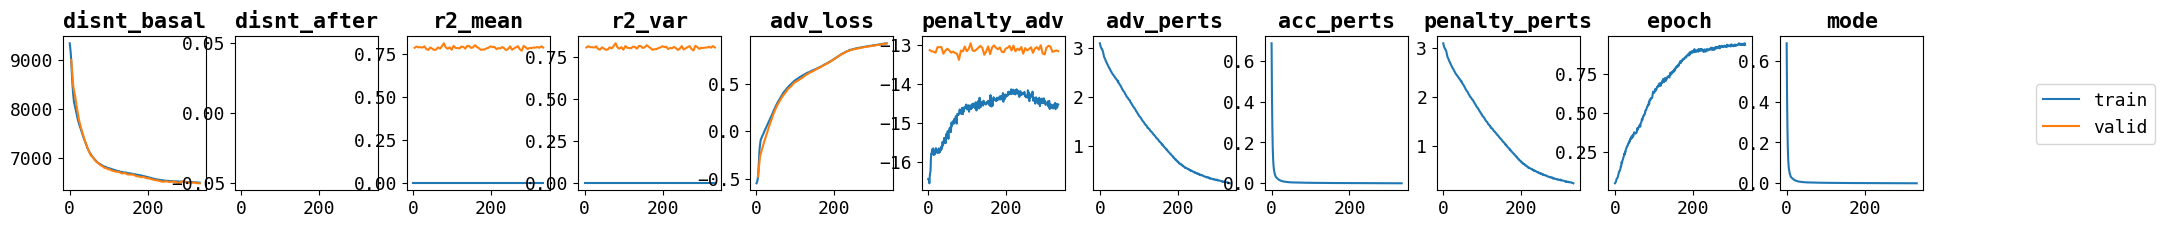

In [81]:
cpa.pl.plot_history(model)

In [82]:
latent_outputs = model.get_latent_representation(adata, batch_size=2048)

INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


100%|██████████| 10/10 [00:00<00:00, 14.54it/s]


In [83]:
latent_outputs.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

In [86]:
sc.pp.neighbors(latent_outputs['latent_basal'])
sc.tl.umap(latent_outputs['latent_basal'])

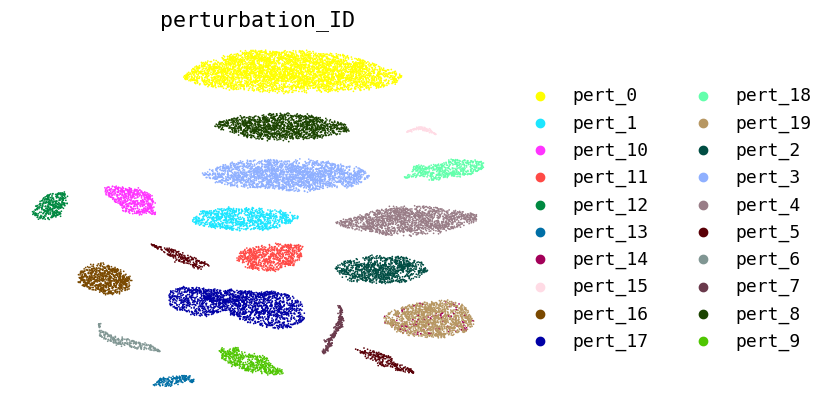

In [85]:
sc.pl.umap(latent_outputs['latent_basal'],
           color='perturbation_ID',
          # groups=groups,
           palette=sc.pl.palettes.godsnot_102,
           frameon=False)

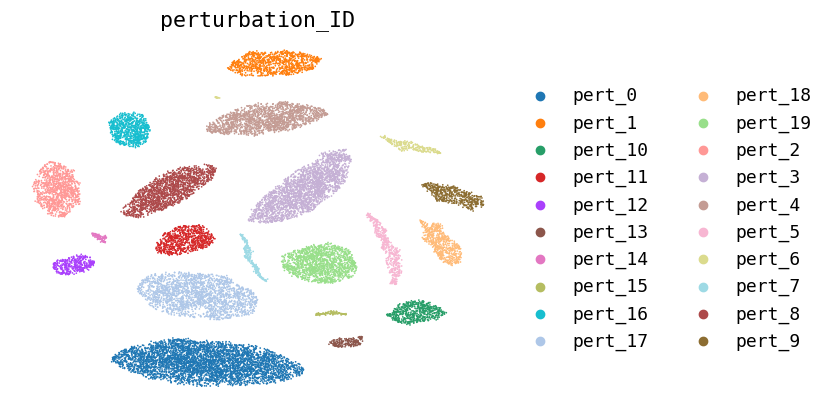

In [88]:
latent_adata = latent_outputs['latent_after']
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)
sc.pl.umap(latent_adata, color=['perturbation_ID'], frameon=False, wspace=0.2)


In [89]:
model.predict(adata, batch_size=1024)


100%|██████████| 20/20 [00:01<00:00, 15.47it/s]


In [90]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from collections import defaultdict
from tqdm import tqdm

n_top_degs = [10, 20, 50, None] # None means all genes

results = defaultdict(list)
ctrl_adata = adata[adata.obs['perturbation_ID'] == 'pert_0'].copy()
for cat in tqdm(adata.obs['cov_drug_dose'].unique()):
    if 'CHEMBL504' not in cat:
        cat_adata = adata[adata.obs['cov_drug_dose'] == cat].copy()

        deg_cat = f'{cat}'
        deg_list = adata.uns['rank_genes_groups_cov'][deg_cat]

        x_true = cat_adata.layers['counts'].toarray()
        x_pred = cat_adata.obsm['CPA_pred']
        x_ctrl = ctrl_adata.layers['counts'].toarray()

        x_true = np.log1p(x_true)
        x_pred = np.log1p(x_pred)
        x_ctrl = np.log1p(x_ctrl)

        for n_top_deg in n_top_degs:
            if n_top_deg is not None:
                degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
            else:
                degs = np.arange(adata.n_vars)
                n_top_deg = 'all'

            x_true_deg = x_true[:, degs]
            x_pred_deg = x_pred[:, degs]
            x_ctrl_deg = x_ctrl[:, degs]

            r2_mean_deg = r2_score(x_true_deg.mean(0), x_pred_deg.mean(0))
            r2_var_deg = r2_score(x_true_deg.var(0), x_pred_deg.var(0))

            r2_mean_lfc_deg = r2_score(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_pred_deg.mean(0) - x_ctrl_deg.mean(0))
            r2_var_lfc_deg = r2_score(x_true_deg.var(0) - x_ctrl_deg.var(0), x_pred_deg.var(0) - x_ctrl_deg.var(0))

            cov, cond, dose = cat.split('_')

            results['cell_type'].append(cov)
            results['condition'].append(cond)
            results['dose'].append(dose)
            results['n_top_deg'].append(n_top_deg)
            results['r2_mean_deg'].append(r2_mean_deg)
            results['r2_var_deg'].append(r2_var_deg)
            results['r2_mean_lfc_deg'].append(r2_mean_lfc_deg)
            results['r2_var_lfc_deg'].append(r2_var_lfc_deg)

df = pd.DataFrame(results)

KeyError: ignored

### Poisson-Gamma mixture $Z_i \sim \Gamma(a_i,b_i)$